## Import & Data Load

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

## Data Pre-processing

In [100]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 
                        'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# # 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)


Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Model Tune for CatBoostRegressor.


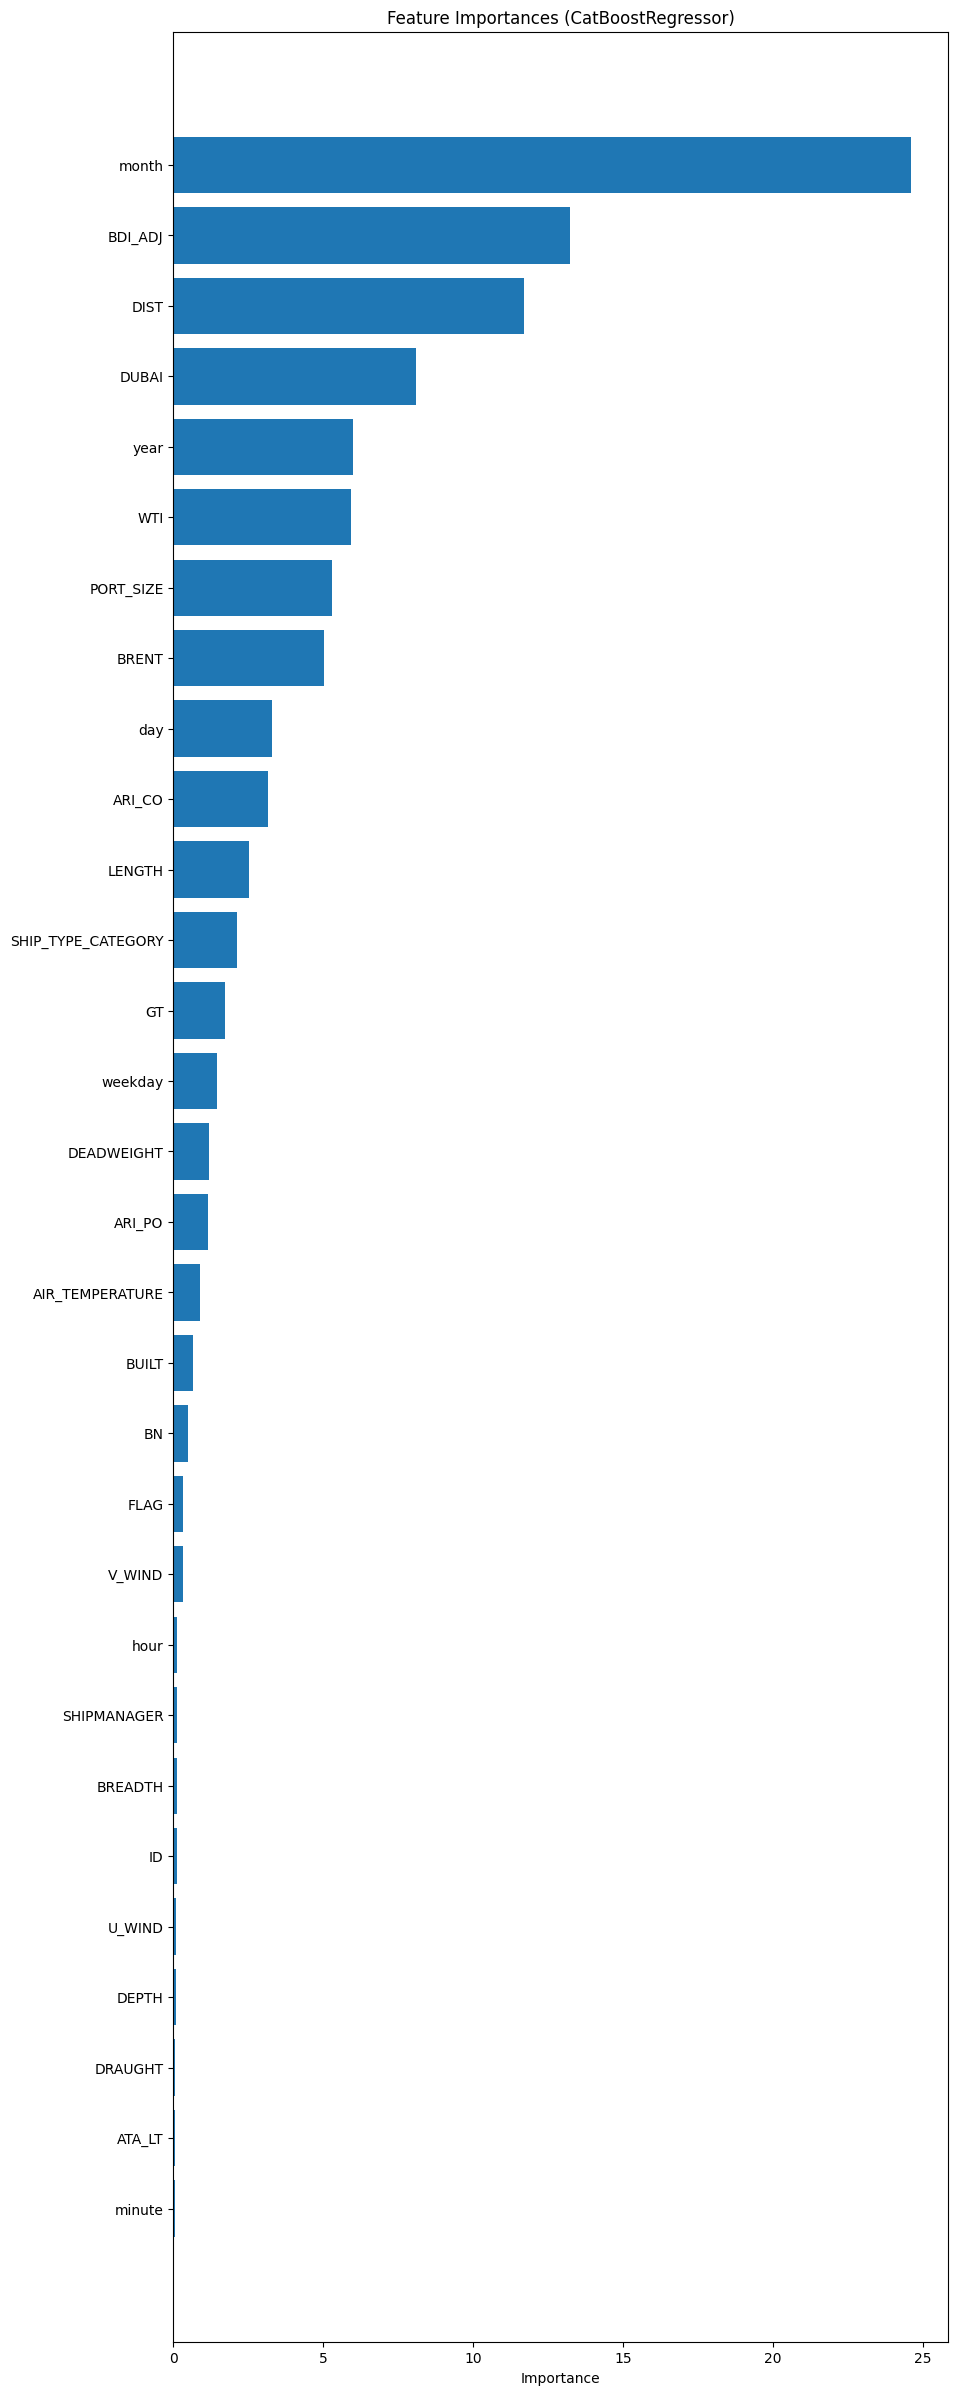

In [101]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor


# 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)



def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(catboost_model, 
                                                        'CatBoostRegressor', X_train, y_train)

In [102]:
# threshold = 4.5 # Your Threshold
# low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

# X_train_reduced = X_train.drop(columns=low_importance_features)
# X_test_reduced = test.drop(columns=low_importance_features)

In [103]:
X_train_reduced = X_train[['DIST', 'DUBAI', 'WTI', 'BDI_ADJ', 'year', 'month', 'day']]

In [104]:
X_train_reduced.columns

Index(['DIST', 'DUBAI', 'WTI', 'BDI_ADJ', 'year', 'month', 'day'], dtype='object')

In [105]:
X_train_reducedss = pd.concat([X_train_reduced, y_train ], axis = 1)

In [106]:
X_train_reducedss.head()

,DIST,DUBAI,WTI,BDI_ADJ,year,month,day,CI_HOUR
0,30.736578,42.01,40.96,1407.668330,2020,10,15,3.048333
1,63.220425,67.53,59.34,2089.046774,2019,9,17,17.138611
2,90.427421,65.30,56.94,603.193047,2019,2,23,98.827500
3,0.000000,43.02,41.11,1169.853455,2020,9,18,0.000000
4,8.813725,90.45,88.11,1107.944894,2022,8,13,96.030556


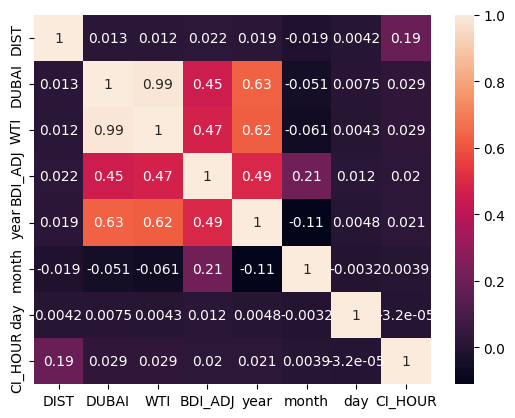

In [107]:
import seaborn as sns
sns.heatmap(X_train_reducedss.corr(), annot = True)
plt.show()

In [108]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

X= X_train_reduced

# 2차 다항식 생성
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)


X_poly.shape


(367441, 36)

In [109]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = X_poly
y = y_train

# 학습 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna를 사용하여 CatBoost 모델의 하이퍼파라미터 최적화를 수행하는 함수를 정의합니다.
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 500, 5000),
        'depth': trial.suggest_int('depth', 5, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 30.0),
        #'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'bootstrap_type': 'MVS',
        'subsample':  trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0] ),
        'random_state': 42,
        'verbose': 0
    }
    
    # CatBoost 모델을 생성합니다.
    model = CatBoostRegressor(**params)

    # 모델을 학습합니다.
    model.fit(X_train, y_train)

    # 검증 데이터로 예측을 수행합니다.
    y_pred = model.predict(X_valid)

    # 평균 절대 오차(MAE)를 계산하여 최소화하도록 최적화합니다.
    mae = mean_absolute_error(y_valid, y_pred)

    return mae

# Optuna 스터디를 생성하고 실행합니다.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # 시행 횟수를 지정할 수 있습니다.

# 최적화된 하이퍼파라미터와 MAE 값을 출력합니다.
best_params = study.best_params
best_mae = study.best_value
print("Best Hyperparameters:", best_params)
print("Best MAE:", best_mae)

[I 2023-10-09 23:14:17,434] A new study created in memory with name: no-name-533ab1a2-b561-4869-a9cb-ec5b3a09ca47
C:\Users\User\AppData\Local\Temp\ipykernel_57284\448648527.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\User\AppData\Local\Temp\ipykernel_57284\448648527.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 30.0),
[W 2023-10-10 00:17:24,314] Trial 0 failed with parameters: {'n_estimators': 4561, 'depth': 14, 'learning_rate': 0.06637615142908317, 'l2_leaf_reg': 0.003607008741109955, 'bootstrap_type': 'MVS', 'subs

KeyboardInterrupt: 

In [ ]:
## catboost 테스트하는 곳